In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [12]:
def crop_model_output_top_right_corner(input_video_path, output_video_path, 
                                frame_width=224, frame_height=224, 
                                crop_width=112, crop_height=112):
    """
    Crop the top-right corner region of each frame in the model output video file and save it as a new video file.
    
    :param input_video_path: Path to the input video file.
    :param output_video_path: Path to the output video file.
    :param frame_width: Width of the input video frames (default is 224).
    :param frame_height: Height of the input video frames (default is 224).
    :param crop_width: Width of the cropped region (default is 112).
    :param crop_height: Height of the cropped region (default is 56).
    """
    
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: unable to open '{input_video_path}'.")
        return
    
    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        fps = 50  # Default fps
        print("Warning：Unable to get the frame rate of the video, use 50 fps as default. ")
    
    # Retrieve the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total number of frames: {total_frames}")
    
    # Set the encoder for the output video: for .avi files, use the 'XVID' encoder
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    cropped_size = (crop_width, crop_height)
    out = cv2.VideoWriter(output_video_path, fourcc, fps, cropped_size)
    
    if not out.isOpened():
        print(f"Error: Can't create file '{output_video_path}'.")
        cap.release()
        return
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("All frames have been processed.")
            break
        
        # Check if the frame dimensions meet the requirements
        if frame.shape[1] != frame_width or frame.shape[0] != frame_height:
            print(f"Warning: The dimensions of frame {frame_count} are {frame.shape[1]}x{frame.shape[0]}, which do not match the expected {frame_width}x{frame_height}.")
            frame = cv2.resize(frame, (frame_width, frame_height))

        x_start = frame_width - crop_width
        y_start = 0
        x_end = frame_width
        y_end = crop_height
        cropped_frame = frame[y_start:y_end, x_start:x_end]
        out.write(cropped_frame)
        
        frame_count += 1

    cap.release()
    out.release()
    print(f"Saved to '{output_video_path}'.")

def enhance_video_contrast(video_path, output_video_path):
    """
    Enhance the contrast of video.
    """
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4)) # Increasing clipLimit enhances contrast
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  
    
        yuv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV) # Convert to YUV color space
        yuv_frame[:, :, 0] = clahe.apply(yuv_frame[:, :, 0])
        enhanced_frame = cv2.cvtColor(yuv_frame, cv2.COLOR_YUV2BGR) # Convert YUV back to BGR format

        out.write(enhanced_frame)

    cap.release()
    out.release()

def extract_video_frames(video_path, output_folder):
    """
    Extract all frames from the given video to a local folder.
    """

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    cap = cv2.VideoCapture(video_path)
    frame_index = 0 
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  
        
        frame_filename = os.path.join(output_folder, f"frame_{frame_index:04d}.png")
        cv2.imwrite(frame_filename, frame)
        frame_index += 1
    
    cap.release()
    print("Finish process.")

In [13]:
def mask_to_short_vlines(masked_image_path, vlines_image_path):
    """
    Transform the red mask regions in the image into a pattern of short vertical lines.
    """
    frame = cv2.imread(masked_image_path)  
    if frame is not None: 
            
        # Convert to HSV color space
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
        # Define the HSV color range for red
        lower_red1 = np.array([0, 120, 70])
        upper_red1 = np.array([10, 255, 255])
    
        lower_red2 = np.array([170, 120, 70])
        upper_red2 = np.array([180, 255, 255])
    
        # Create masks
        mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
    
        # Merge the two masks
        red_mask = mask1 | mask2
    
        fig, ax = plt.subplots()
        slope_factor = 0.1  # Set the slope ratio coefficient; adjusting this value can change the angle of the diagonal lines
        first_midpoint = None
        last_midpoint = None
    
        # Find the left and right contours of the mask
        for y in range(0, red_mask.shape[0], 15):  # Iterate every 3 rows
            row = red_mask[y, :]  # Extract all the pixel points in the current row
            
            if np.any(row > 0): 
                left_idx = np.argmax(row > 0) 
                right_idx = red_mask.shape[1] - np.argmax(np.flip(row) > 0) - 1
    
                if left_idx < right_idx:  
                    delta_x = right_idx - left_idx
                    delta_y = slope_factor * delta_x
                    ax.plot([left_idx, right_idx], [y, y - delta_y], color='black') 
                    midpoint_x = (left_idx + right_idx) / 2
                    midpoint_y = (y + (y - delta_y)) / 2 
                    if first_midpoint is None:
                        first_midpoint = (midpoint_x, midpoint_y)
                    last_midpoint = (midpoint_x, midpoint_y)
    
        # Draw a vertical axis from the midpoint of the first short axis to the midpoint of the last short axis
        if first_midpoint is not None and last_midpoint is not None:
            ax.plot([first_midpoint[0], last_midpoint[0]], [first_midpoint[1], last_midpoint[1]], color='black', linewidth=2)  # 竖轴颜色更深，线宽更大
    
        ax.set_facecolor('white')  
        ax.set_xlim([0, red_mask.shape[1]]) 
        ax.set_ylim([0, red_mask.shape[0]])  
        ax.invert_yaxis() 
        ax.set_xticks(np.arange(0, red_mask.shape[1], 180)) 
        ax.set_yticks(np.arange(0, red_mask.shape[0], 180))  
        ax.grid(False) 
        ax.set_aspect('equal') # Maintain the aspect ratio of the image to prevent distortion
        plt.show()
        
        plt.savefig(vlines_image_path, bbox_inches='tight') 
        print(f"Saved to {vlines_image_path}.")
    else:
        print("Unable to load.")
        
def plot_size_change_over_frames(video_path, output_image_path, title, color, figure_type, start_frame=0, end_frame=150):
    """
    Plot the area change curve from the start frame to the end frame and save it as a local image.

    Args:
        video_path: Path to the input video.
        output_path: Path to save the output curve image.
        start_frame: Starting frame.
        end_frame: Ending frame.
        title: Title of the output image.
        color: Color of the curve.
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    mask_areas = []
    frame_numbers = [] 
    
    for frame_idx in range(start_frame, end_frame + 1):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Unable to read frame {frame_idx}.")
            break

        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_red1 = np.array([0, 120, 70])
        upper_red1 = np.array([10, 255, 255])
    
        lower_red2 = np.array([170, 120, 70])
        upper_red2 = np.array([180, 255, 255])

        mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
        red_mask = mask1 | mask2
        mask_area = np.count_nonzero(red_mask)
        mask_areas.append(mask_area)
        frame_numbers.append(frame_idx - start_frame)
    
    cap.release()

    mask_areas_np = np.array(mask_areas)
    local_minima_indices, _ = find_peaks(-mask_areas_np, distance=50)
    plt.figure()
    plt.plot(frame_numbers, mask_areas, color=color, linewidth=0.8)
    plt.xlabel('Frame')
    plt.ylabel('Segmentation Area')
    plt.gca().yaxis.set_ticks([]) 
    if (figure_type == "tight"):
        plt.gca().xaxis.set_ticks([])  
        plt.gcf().set_size_inches(2, 2)  # 调整图像大小，使其更紧凑
        plt.subplots_adjust(left=0.05, right=0.95, top=0.90, bottom=0.10)  # 减小边距，使绘图区域更紧凑
    else:
        plt.gca().yaxis.set_ticks([]) # Remove y-axis ticks.
        plt.xticks(np.arange(start_frame, end_frame+1, 25)) # Set x-axis ticks at intervals of 25.
        plt.title(title)
        plt.gcf().set_size_inches(6, 3)
    
    for idx in local_minima_indices:
        start_idx = max(0, idx - 13)
        end_idx = min(len(frame_numbers) - 1, idx + 13)
        plt.axvspan(frame_numbers[start_idx], frame_numbers[end_idx], color="gray", alpha=0.25)
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.savefig(output_image_path, bbox_inches='tight')
    print(f"Figure saved to {output_image_path}.")
    plt.show()
    return local_minima_indices

def plot_predicted_EF(file_path, output_image_path, color, start_frame, end_frame, local_minima_indices):
    """
   Read frame numbers and predicted ejection fraction data from an Excel file.

    Args:
    - file_path: str, path to excel file.
    - output_image_path: str, path to output image file. 
    """

    df = pd.read_excel(file_path)
    frame_numbers = df.iloc[start_frame:end_frame, 1]  
    ejection_fraction = df.iloc[start_frame:end_frame, 2]  
    plt.figure()
    plt.plot(frame_numbers, ejection_fraction, color=color, linewidth=0.8)
    plt.xlabel('Frame')
    plt.ylabel('Model prediction of ejection fraction')
    plt.ylim(28, 70)  
    plt.gcf().set_size_inches(6, 3)

    plt.xticks(np.arange(start_frame, end_frame+1, 25)) 

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    for idx in local_minima_indices:
        start_idx = max(0, idx - 13)
        end_idx = min(len(frame_numbers) - 1, idx + 13)
        plt.axvspan(frame_numbers[start_idx], frame_numbers[end_idx], color="gray", alpha=0.25)
    plt.savefig(output_image_path, bbox_inches='tight')
    print(f"Saved to {output_image_path}.")
    plt.show()

In [14]:
def calculate_three_positions(input_video_path, output_video_path):
    if not os.path.exists(input_video_path):
        print(f"{input_video_path} doesn't exist.")
        exit()
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Can't open file. ")
        exit()
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
    frame_size = (frame_width, frame_height)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 

    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)
    
    frame_count = 0 

    while True:
        ret, frame = cap.read()  
        if not ret:
            break 
    

        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        lower_red1 = np.array([0, 120, 70])
        upper_red1 = np.array([10, 255, 255])
    
        lower_red2 = np.array([170, 120, 70])
        upper_red2 = np.array([180, 255, 255])
    
        mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
    
        red_mask = mask1 | mask2
    
        ys = np.where(red_mask.any(axis=1))[0]
    
        if ys.size == 0:
            annotated_frame = frame.copy()
            out.write(annotated_frame)
            frame_count += 1
            continue
    
        min_y = ys.min()
        max_y = ys.max()
    
        three_quarter_height = int(min_y + (max_y - min_y) / 4)
    
        # Define search range (e.g. search 5 pixels upward and downward)
        search_range = 5
        markers = []
    
        # Mark Position 2: at halfway of the left boundary.
        found_2 = False
        target_point_2 = None
        half_height = frame_height // 2
    
        for offset in range(search_range + 1):
            for direction in [-1, 1]:
                y = half_height + direction * offset
                if y < 0 or y >= frame_height:
                    continue  
                x_indices = np.where(red_mask[y] != 0)[0]
                if x_indices.size > 0:
                    min_x = x_indices.min()
                    target_point_2 = (min_x, y)
                    found_2 = True
                    break
            if found_2:
                break
    
        if found_2 and target_point_2 is not None:
            markers.append(('2', target_point_2))
        else:

            pass
    
        # Mark Position 3: at the lowest point of the left boundary
        left_boundary_points = []
        for y in range(frame_height):
            x_indices = np.where(red_mask[y] != 0)[0]
            if x_indices.size > 0:
                min_x = x_indices.min()
                left_boundary_points.append((min_x, y))
    
        if left_boundary_points:
            target_point_3 = max(left_boundary_points, key=lambda pt: pt[1])
            markers.append(('3', target_point_3))
        else:
            pass
    
        # Mark position 4: three-quarters up the right boundary
        found_4 = False
        target_point_4 = None
    
        for offset in range(search_range + 1):
            for direction in [-1, 1]:
                y = three_quarter_height + direction * offset
                if y < 0 or y >= frame_height:
                    continue 
                x_indices = np.where(red_mask[y] != 0)[0]
                if x_indices.size > 0:
                    max_x = x_indices.max()
                    target_point_4 = (max_x, y)
                    found_4 = True
                    break
            if found_4:
                break
    
        if found_4 and target_point_4 is not None:
            markers.append(('4', target_point_4))
        else:
            pass
    
        annotated_frame = frame.copy()
        for label, point in markers:
            cv2.circle(annotated_frame, point, radius=13, color=(10, 255, 0), thickness=-1)
            cv2.putText(annotated_frame, label, (point[0] - 8, point[1] +7 ),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            coordinate_text = f"({point[0]}, {point[1]})"
            cv2.putText(annotated_frame, coordinate_text, (point[0] + 15, point[1] + 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 165, 255), 2, cv2.LINE_AA)
        out.write(annotated_frame)
    
        frame_count += 1
    
    cap.release()
    out.release()
    print(f"Saved to {output_video_path}.")

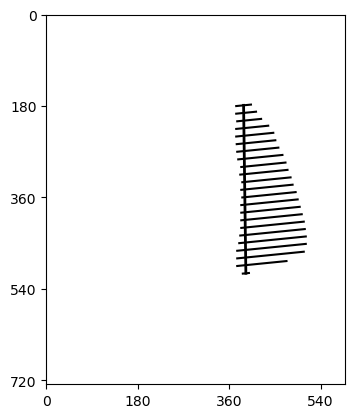

Saved to results/vlines_frame_0094.png.
Figure saved to 0X1131FB2A374D34F5_112_size_plot.png.


<Figure size 640x480 with 0 Axes>

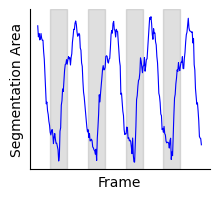

In [15]:
if __name__ == "__main__":
    masked_image_path = 'results/frame_0094.png'
    vlines_image_path = 'results/vlines_frame_0094.png'
    mask_to_short_vlines(masked_image_path, vlines_image_path)

    video_path = 'videos/0X1131FB2A374D34F5_112.avi' 
    size_change_image_path = '0X1131FB2A374D34F5_112_size_plot.png'
    start_frame = 0  # 19
    end_frame = 250  # 94
    title = 'Patient in Atrial Fibrillation'
    color = 'blue'
    figure_type = 'tight'
    local_minima_indices = plot_size_change_over_frames(video_path, size_change_image_path, title, color, figure_type, start_frame, end_frame)
    # plot_predicted_EF("videos/0X2D4304FA6A09F93E_predicted_EF.xlsx", "predicted_EF_curve.png", color, start_frame, end_frame, local_minima_indices)